# DogFaceNet version 8: clean version

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
from triplets_processing import *

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print("Total number of images: "+str(len(labels)))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)
    
# Normalization
images /= 255.0

nbof_classes = len(np.unique(labels))
print("Total number of classes: " + str(nbof_classes))

Total number of images: 3148
Total number of classes: 485


Open-set: test set

In [4]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

### Loss definition

In [5]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

### Metric definition

In [6]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

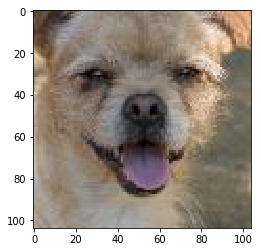

In [9]:
plt.imshow(images[0])

### Model definition

In [7]:
# Load saved model
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.20.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [8]:
model.predict(images[0:2])

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_10/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_10/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_10/Conv2D/ReadVariableOp)]]
	 [[{{node lambda_2/l2_normalize/_959}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_343_lambda_2/l2_normalize", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

### Model evaluation

#### Evaluate on verification task

In [7]:
NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = np.empty((NBOF_PAIRS*2,h,w,c))
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

NameError: name 'labels_test' is not defined

In [21]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)


best = 0
best_t = 0
thresholds = np.arange(0.0001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 0.5761000000000001
Best accuracy: 0.967


### ROC curve

Text(0.5, 1.0, 'ROC curve')

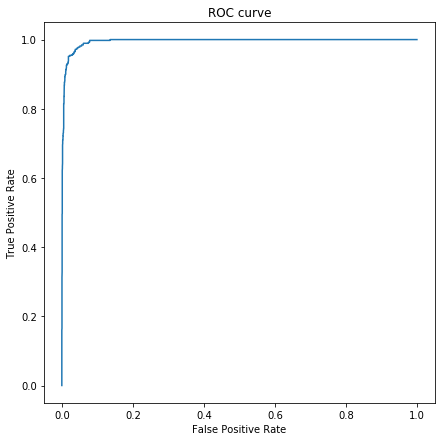

In [20]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Computes the ROC depending on different thresholds

thresholds = np.arange(0.0001,4,0.001)
tprs = np.empty(len(thresholds))
fprs = np.empty(len(thresholds))

p = np.sum(issame.astype(float))
n = np.sum(np.logical_not(issame).astype(float))

for i in range(len(thresholds)):
    logical_pred = np.less(dist, thresholds[i])
    tp = np.sum(np.logical_and(logical_pred,issame).astype(float))
    fp = np.sum(np.logical_and(logical_pred,np.logical_not(issame)).astype(float))
    tprs[i] = tp/p
    fprs[i] = fp/n
    
plt.figure(figsize=(7,7))
plt.plot(fprs,tprs)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")

### Face clustering

In [22]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [23]:
from sklearn.cluster import KMeans

In [24]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.576).fit(predict)

In [25]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

[47. 47. 47. 47. 47.]


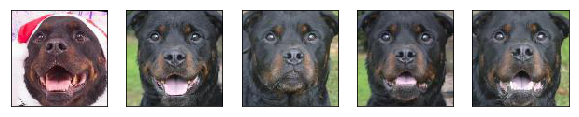

[8. 8. 8. 8. 8. 8. 8.]


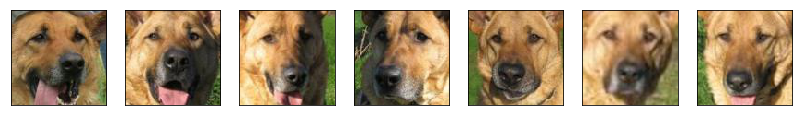

[40. 40. 40. 40. 40. 40.]


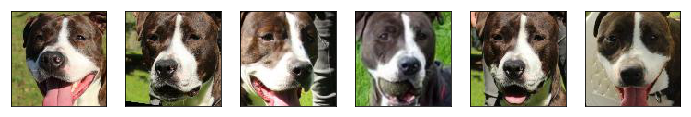

[44. 44. 44. 44. 44. 44. 44. 44. 44. 44.]


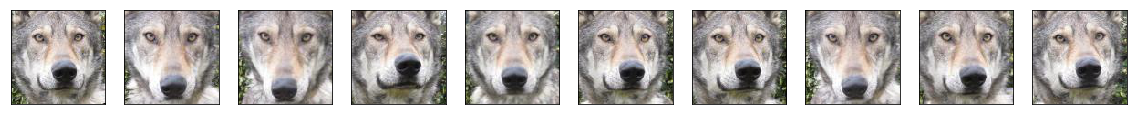

[17. 17. 17. 17. 17. 17. 17. 17.]


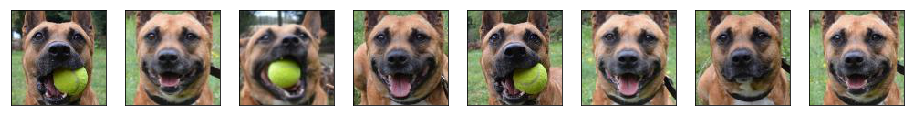

[ 5.  5.  5. 16. 16. 16. 16. 16. 16. 16.]


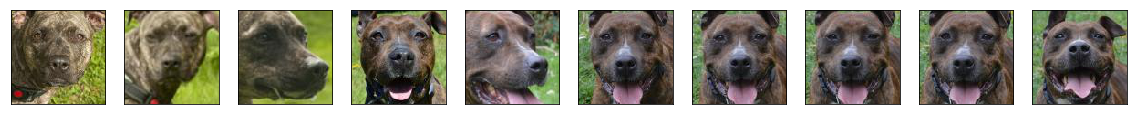

[26. 26. 26. 26. 26.]


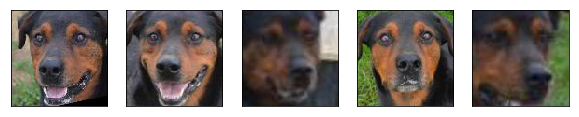

[7. 7. 7. 7. 7. 7. 7.]


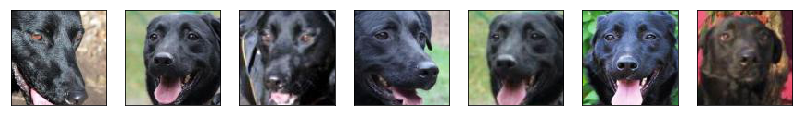

[1. 1. 1. 1. 1. 3. 3. 3. 3. 3.]


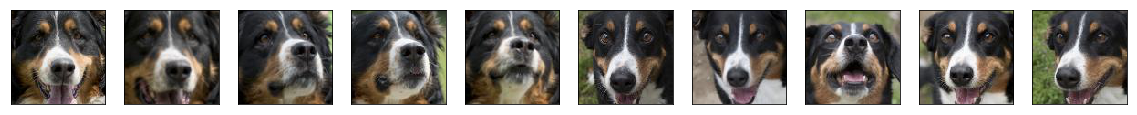

[15. 15. 15. 15. 15.]


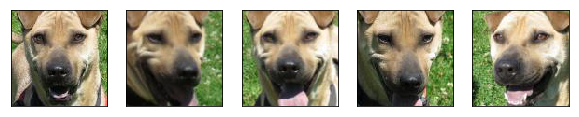

[43. 43. 43. 43. 43. 43. 43.]


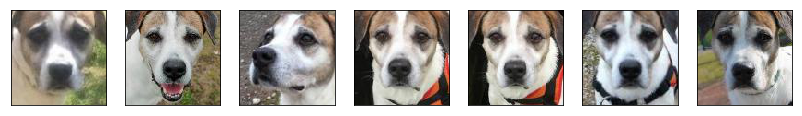

[13. 42.]


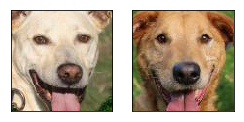

[41. 41. 41. 41. 41. 41. 41. 41.]


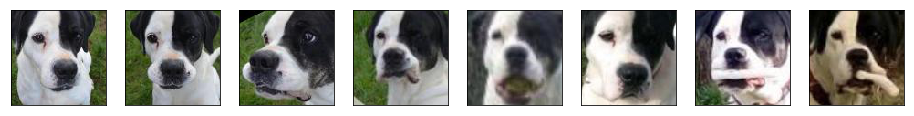

[46. 46.]


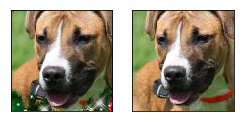

[23. 23. 23. 23. 23.]


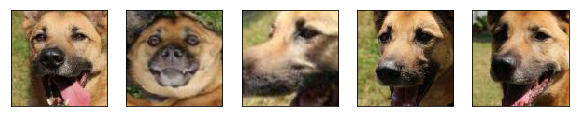

[27. 27. 27. 27. 27. 27.]


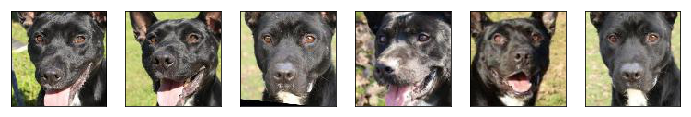

[14. 14. 14. 14. 14. 14. 46.]


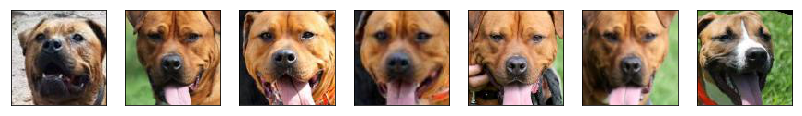

[29. 29. 29. 29. 29. 29.]


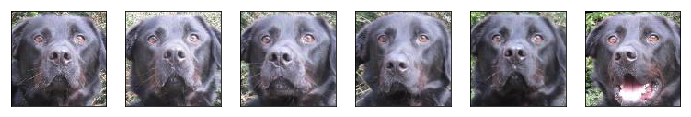

[4. 4. 4. 4. 4. 4.]


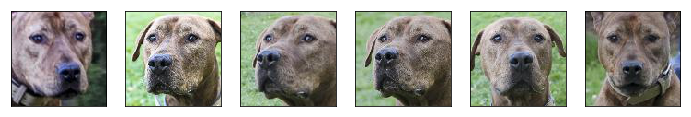

[31. 32. 32. 32. 32. 32. 32. 32. 32.]


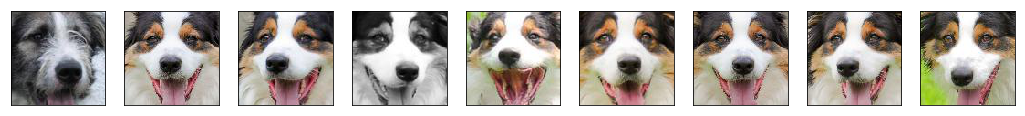

[33. 33. 33. 33. 33. 33. 33.]


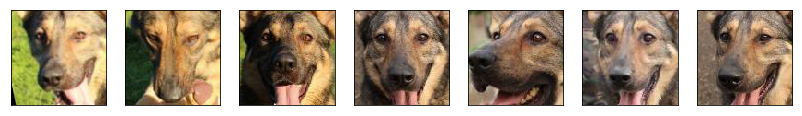

[36. 36. 36. 36. 36.]


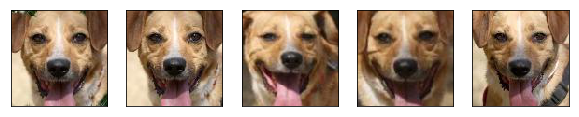

[6. 6. 6. 6. 6. 6. 6.]


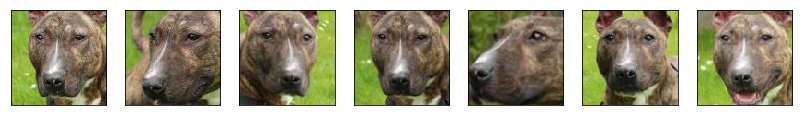

[24. 24. 24. 24. 24.]


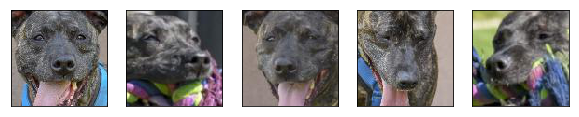

[2. 2. 2. 2. 2. 2.]


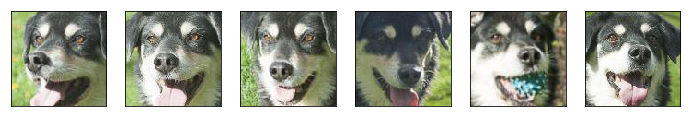

[38. 38. 38. 38. 38. 38. 38.]


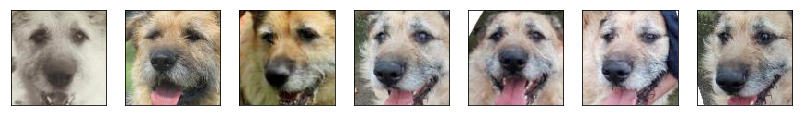

[22. 22. 22. 22. 22.]


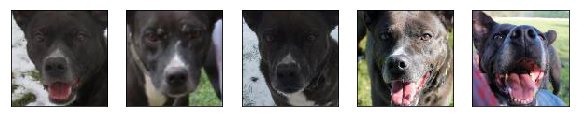

[0. 0. 0. 0. 0.]


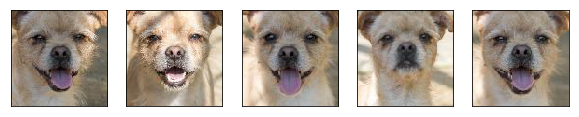

[9. 9. 9. 9.]


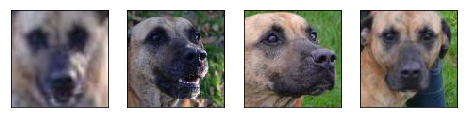

[21. 21. 21. 21. 21. 21. 21. 23. 23.]


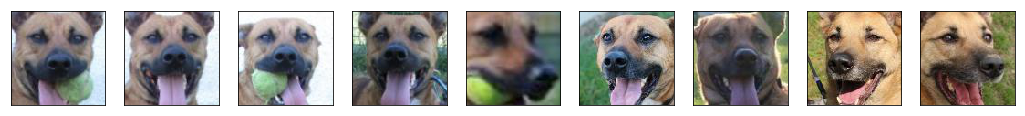

[11. 11.]


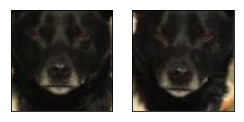

[10. 10. 10. 10. 10.]


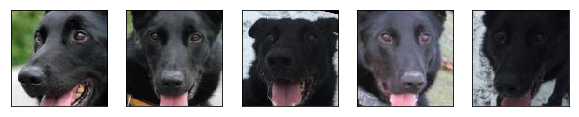

[18. 18. 18. 18. 18.]


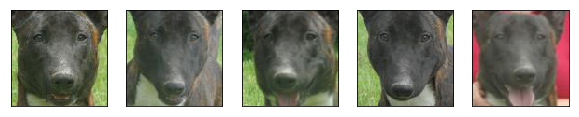

[28. 28. 28. 28.]


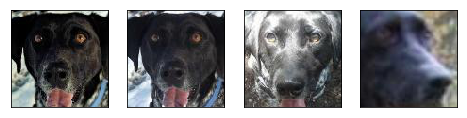

[31. 31. 31. 31.]


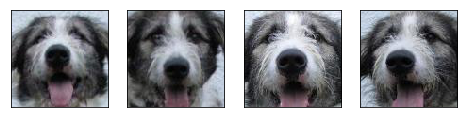

[20. 20. 20. 20. 20. 37. 37. 37.]


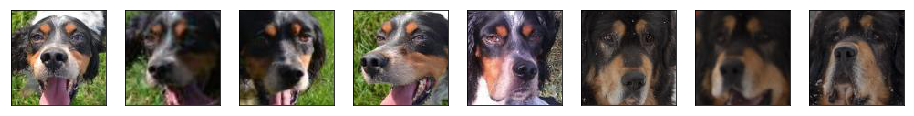

[39. 39. 39. 39. 39.]


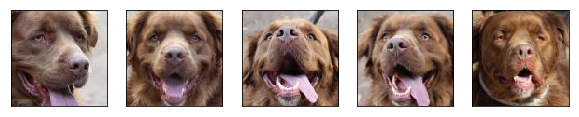

[42. 42. 42. 42. 42. 42. 42.]


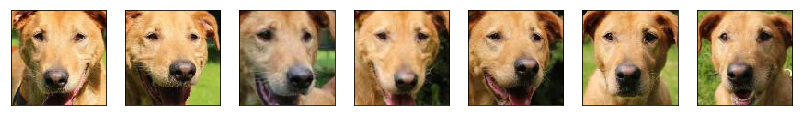

[30. 30. 30. 30. 30.]


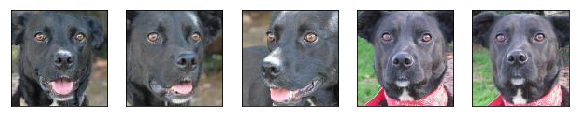

[19. 19.]


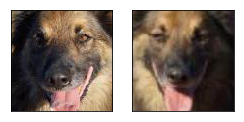

[12. 12. 12. 12. 12. 12. 12. 12. 21.]


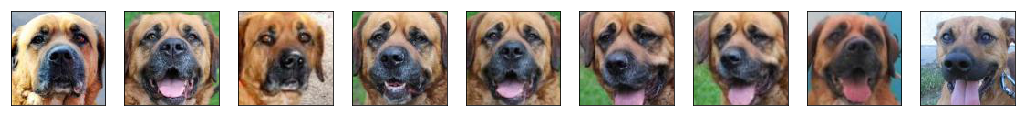

[45. 45. 45. 45.]


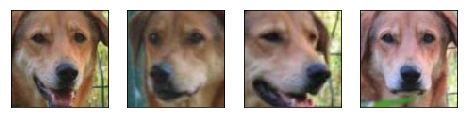

[46. 46.]


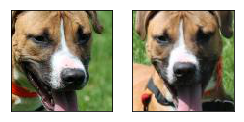

[25. 25. 25.]


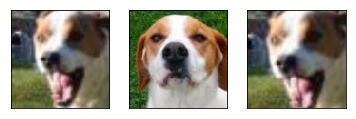

[34. 34. 34. 34. 34.]


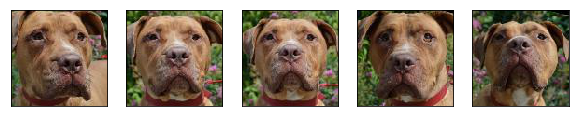

[35. 35. 35. 35. 35.]


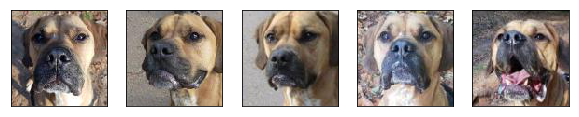

[13. 13. 13. 13. 13.]


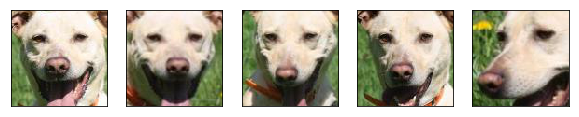

[11.]


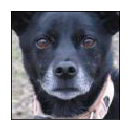

In [40]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        #fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn11.clustering.'+str(i)+'.png')

### Recognition

In [32]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [33]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [34]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [37]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [38]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=30)

Epoch 1/30
298/298 [==============================] - 2s 6ms/step - loss: 1538.4350 - acc: 0.0268
Epoch 2/30
298/298 [==============================] - 0s 2ms/step - loss: 1354.1154 - acc: 0.0638
Epoch 3/30
298/298 [==============================] - 0s 2ms/step - loss: 1187.7325 - acc: 0.1174
Epoch 4/30
298/298 [==============================] - 0s 2ms/step - loss: 1051.1713 - acc: 0.1443
Epoch 5/30
298/298 [==============================] - 0s 2ms/step - loss: 919.2649 - acc: 0.2315
Epoch 6/30
298/298 [==============================] - 0s 2ms/step - loss: 819.8516 - acc: 0.2852
Epoch 7/30
298/298 [==============================] - 0s 2ms/step - loss: 778.0952 - acc: 0.3289
Epoch 8/30
298/298 [==============================] - 0s 2ms/step - loss: 702.3572 - acc: 0.3859
Epoch 9/30
298/298 [==============================] - 0s 2ms/step - loss: 668.3348 - acc: 0.4060
Epoch 10/30
298/298 [==============================] - 0s 2ms/step - loss: 624.9931 - acc: 0.4698
Epoch 11/30
298/298 [====

### Observation on the heatmap

In [39]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

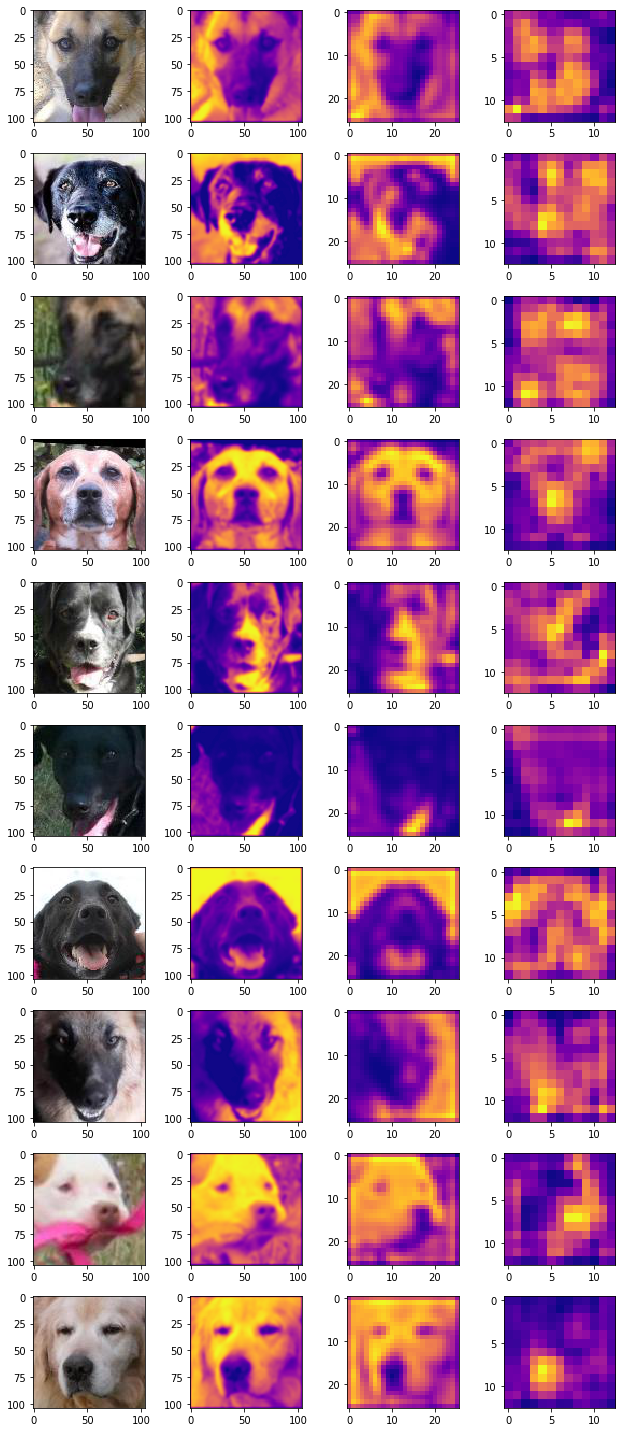

In [44]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')